In [169]:
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
from scipy.spatial.distance import euclidean

In [170]:
def sim_matrix(spectrogram):
    num_frames = spectrogram.shape[0]
#     print("Number of frames: " + str(num_frames))
    S = np.ndarray(shape=(num_frames, num_frames))
    for i in range(num_frames):
        for j in range(num_frames):
            S[i, j] = 1 - cosine(spectrogram[i], spectrogram[j])
    return S

In [171]:
def beat_spectrum(y, sr, S):
    # beat_spectrum = np.correlate(S[0], S[0], mode='full')
    # beat_spectrum = beat_spectrum[:len(beat_spectrum) // 2]
    duration = librosa.core.get_duration(y, sr)
    frames_per_sec = S.shape[0] / duration
    lag_range = 10
    num_frames = int(lag_range * frames_per_sec) - 1
#     print(num_frames)
    bs = []
    for l in range(num_frames):
        sum = np.sum([S[i, i + l] for i in range(len(S) - num_frames)])
#         sum /= (len(S) - num_frames)
        bs.append(sum)
#     mean = np.mean(bs)
#     bs -= mean
    return bs

In [172]:
def robust_beat_spectrum(y, sr, S):
    duration = librosa.core.get_duration(y, sr)
    frames_per_sec = S.shape[0] / duration
    lag_range = duration
    num_frames = int(lag_range * frames_per_sec) - 1
    bs = []
    print(num_frames)
    for l in range(num_frames):
        sum = 0
        for i in range(num_frames):
            for j in range(num_frames - l):
                sum += S[i][j] * S[i][j + l]
        print(sum)
        bs.append(sum)
    return bs

In [173]:
def plot_spectrogram(spectrogram):
    plt.figure(figsize=(10, 4))
    S_dB = librosa.power_to_db(spectrogram, ref=np.max)
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

In [174]:
class SongEntry:
    def __init__(self, y, sr, id):
        self.y = y
        self.sr = sr
        self.id = id
        self.init_beat_spectrum()

    def init_beat_spectrum(self):
        spectrogram = librosa.feature.melspectrogram(y=self.y, sr=self.sr, n_mels=128)
        S = sim_matrix(spectrogram)
        bs = beat_spectrum(y=self.y, sr=self.sr, S=S)
        self.bs = bs
    
    def cos_sim(self, songEntry):
        return 1 - cosine(self.bs, songEntry.bs)

In [175]:
def retrieveNearestK(query, db, k):
    sims = list()
    for entry in db:
        sim = query.cos_sim(entry)
        sims.append((entry.id, sim))
    sims.sort(key=lambda tup: tup[1], reverse=True)
    neighbors = list()
    for i in range(k):
        neighbors.append(sims[i][0])
    return neighbors        

In [176]:
def get_accuracy(db, queries, k): #lists of SongEntry's
    num_correct = 0
    for query in queries:
        nearestK = retrieveNearestK(query=query, db=db, k=k)
        for id in nearestK:
            if (id == query.id):
                num_correct += 1
            else:
                print('query id: ' + str(query.id) + ', db id: ' + str(id))
    total = len(queries) * k
    return num_correct / total

In [177]:
data_dir = os.path.join(os.getcwd(), '..\\data\\')
data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir)]
songDB = []
queries = []
songs_per_query = 2
for data_file in data_files:
    y, sr = librosa.load(data_file, duration=10)
    a = SongEntry(y, sr, data_file)
    queries.append(a)
    for i in range(1, 1 + songs_per_query):
        y, sr = librosa.load(data_file, duration=10, offset=i*10)
        a = SongEntry(y, sr, data_file)
        songDB.append(a)
print(str(len(queries)) + ' query samples and ' + str(len(songDB)) + ' DB samples saved')

6 query samples and 12 DB samples saved


In [178]:
accuracy = get_accuracy(db=songDB, queries=queries, k=songs_per_query)
print('Accuracy: ' + str(accuracy))

query id: C:\Users\phili\PycharmProjects\RhythmSearch\notebooks\..\data\bensound-hipjazz.wav, db id: C:\Users\phili\PycharmProjects\RhythmSearch\notebooks\..\data\bensound-epic.wav
query id: C:\Users\phili\PycharmProjects\RhythmSearch\notebooks\..\data\bensound-hipjazz.wav, db id: C:\Users\phili\PycharmProjects\RhythmSearch\notebooks\..\data\bensound-epic.wav
query id: C:\Users\phili\PycharmProjects\RhythmSearch\notebooks\..\data\bensound-thejazzpiano.wav, db id: C:\Users\phili\PycharmProjects\RhythmSearch\notebooks\..\data\bensound-badass.wav
Accuracy: 0.75


C:\Users\phili\PycharmProjects\RhythmSearch\notebooks\..\data\bensound-badass.wav


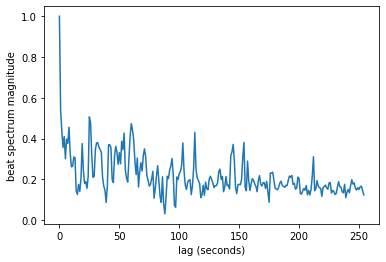

In [167]:
spectrogram = librosa.feature.melspectrogram(y=queries[0].y, sr=queries[0].sr, n_mels=256)
S = sim_matrix(spectrogram)
bs = beat_spectrum(y=queries[0].y, sr=queries[0].sr, S=S)
# print(queries[1].id)
# plt.xlabel('lag (seconds)')
# plt.ylabel('beat spectrum magnitude')
# plt.plot(bs)
# plt.plot(songDB[7].bs)

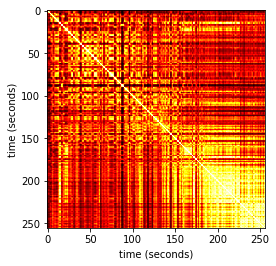

In [162]:
S /= (S.shape[0] / 10)
plt.imshow(S, cmap='hot', interpolation='nearest')
plt.xlabel('time (seconds)')
plt.ylabel('time (seconds)')
plt.show()

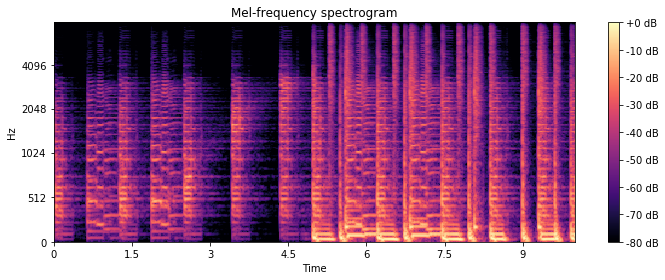

In [168]:
# spectrogram = librosa.feature.melspectrogram(y=queries[0].y, sr=queries[0].sr, n_mels=256)
# S = sim_matrix(spectrogram)
# bs = beat_spectrum(y=queries[0].y, sr=queries[0].sr, S=S)
plot_spectrogram(spectrogram)
# print(queries[2].id)
# plt.plot(queries[2].bs)
# plt.plot(songDB[10].bs)

#### 